# COMPSCI 589 HW1

#### Name: Haochen Wang

### SECTION 0: Load Libraries

In [236]:
import sklearn.model_selection
import scipy
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
from operator import itemgetter
from collections import Counter

### SECTION 2: Evaluating Decision Tree

In [237]:
# Import Document

house_file = open('house_votes_84.csv', encoding='utf-8-sig')
csvreader = csv.reader(house_file)
houserows = []
for row in csvreader:
    houserows.append(row)

hvcat = houserows[0]
# print(housevotecat)

def catindex(categoryname: str): # a small helper function
    return hvcat.index(categoryname)

#housevotedat = np.array([[int(element) for element in row] for row in houserows[1:]]).T
housevotedat = np.array(houserows[1:]).astype(int)

# print(len(housevotedat))

In [238]:
# Split to test and training data.

def split_test_train(data, rand):
    housetra, housetes = sklearn.model_selection.train_test_split(data, train_size=0.8, test_size=0.2, random_state=rand, shuffle=True)
    return housetra.T, housetes.T

# housetrain, housetest = split_test_train(housevotedat, 11589)


In [239]:
# Node Class
class Treenode:
    type = ""
    label = None
    testattribute = ""
    edge = {}
    majority = -1
    # threshold = -1  We don't have numerical here.

    def __init__(self, label, type):
        self.label = label
        self.type = type
        # self.left = left
        # self.right = right

In [240]:
# Define helper functions that I use in decision tree.

def same(column):
    return all(item == column[0] for item in column)

def majority(column):
    return np.argmax(np.bincount(column))

def entropy(col):
    values = list(Counter(col).values())
    ent = 0
    for value in values:
        k = (value/sum(values))
        ent += -k*math.log(k,2)
    return ent

def gini(col):
    values = list(Counter(col).values())
    ginivalue = 1
    for value in values:
        prob = (value/sum(values))
        ginivalue -= prob**2
    return ginivalue

# test = np.array([1,1,3,3,11,11])
# same(test)
# majority(test)

# test1 = np.array([1,1,0,0,0]) # should get entropy .971, gini .48
# test2 = np.array([1,1,1,1,1,0,0,0,0,0,0,0,0,0]) # should get entropy .940, gini.459
# entropy(test2)
# gini(test2)

In [241]:
# Define three test criteria: 
    
# ID3 - Entropy Gain 

def id3(collist, listattribution):
    original_ent = entropy(collist[-1])
    smallest_ent = 1
    i = 0

    # bestindex = i
    best = listattribution[i]
    for attributes in listattribution[:-1]: # I keep the last column: the target/label.
        liskey = list(Counter(collist[i]).keys())
        listofcategory = []
        for value in liskey:
            index = [idx for idx, element in enumerate(collist[i]) if element == value]
            category = np.array(collist[-1][index]) 
            listofcategory.append(category) # list of nparrays of target/label/categories.

        ent = 0
        for cat in listofcategory:
            a = len(cat)/len(collist[i]) # This is probability
            ent += a * entropy(cat) # probability multiple by entropy

        if ent < smallest_ent:
            smallest_ent = ent
            best = attributes
            # bestindex = i
        i+=1

    return best, original_ent-ent

# C4.5 - Entrophy Ratio 
# CART - Gini Impurity
def cart(collist, listattribution):
    smallest_gini = 1
    i = 0
    # bestindex = i
    best = listattribution[i]
    for attributes in listattribution[:-1]: # I keep the last column: the target/label.
        liskey = list(Counter(collist[i]).keys())
        listofcategory = []
        for value in liskey:
            index = [idx for idx, element in enumerate(collist[i]) if element == value]
            category = np.array(collist[-1][index]) 
            listofcategory.append(category) # list of nparrays of target/label/categories.

        gin = 0
        for cat in listofcategory:
            a = len(cat)/len(collist[i]) # This is probability
            gin += a * gini(cat) # probability multiple by gini

        if gin < smallest_gini:
            smallest_gini = gin
            best = attributes
            # bestindex = i
        i+=1

    return best, gin
    

In [242]:
# Decision Tree
def decisiontree(dataset: np.array, listattributes: list, algortype: str ='id3'):
    def processbest(algor):
        if algor == "id3" or algor == "infogain":
            return id3(datasetcopy, listattricopy)
        elif algor == "cart" or algor == "gini":
            return cart(datasetcopy, listattricopy)
        else: 
            return cart(datasetcopy, listattricopy)

    datasetcopy = np.copy(dataset)
    listattricopy = listattributes.copy()
    
    node = Treenode(label=-1,type="decision")

    node.majority = majority(datasetcopy[-1])

    if same(datasetcopy[-1]):
        node.type = "leaf"
        node.label = datasetcopy[-1][0]
        return node
    
    if len(listattricopy) == 0:
        node.type = "leaf"
        node.label = majority(datasetcopy[-1])
        return node

    bestattribute = processbest(algortype)[0]
    node.testattribute = bestattribute
    bindex = listattricopy.index(bestattribute)

    bigv = list(Counter(datasetcopy[bindex]).keys())

    subdatalists = []
    for smallv in bigv:
        index = [idx for idx, element in enumerate(datasetcopy[bindex]) if element == smallv]
        subdatav = np.array(datasetcopy.T[index]).T
        subdatav = np.delete(subdatav,bindex,0)  # I delete the column I already used using bindex as reference. 
        # Then, later, pop the same index from list attribute.
        subdatalists.append(subdatav) # list of nparrays of target/label/categories.

    listattricopy.pop(bindex)
    
    edge = {}
    sdindex = 0
    for subvdata in subdatalists:
        if subvdata.size == 0:
            node.type = "leaf"
            node.label = majority(subdatav[-1])

        subtree = decisiontree(subvdata, listattricopy, algortype)
        attributevalue = bigv[sdindex]
        edge[attributevalue] = subtree
        sdindex += 1

    node.edge = edge

    return node

In [243]:
# Prediction using tree

def prediction(tree: Treenode, instance): # note that the instance if by row. (I formerly used by column)
    predict = tree.majority
    correct = instance[-1]
    if tree.type == 'leaf':
        predict = tree.label
        return predict==correct, predict, correct

    testindex = catindex(tree.testattribute)

    if instance[testindex] not in tree.edge:
        return predict==correct, predict, correct
 
    nexttree = tree.edge[instance[testindex]]

    return prediction(nexttree, instance)
    

In [244]:
# Test with one instance

# instance1 = np.array([1,2,2,1,1,1,2,2,2,1,1,1,2,1,0,0,0])
# print(firsttree.edge[0].edge[2].edge[2].type)
# print(prediction(firsttree,instance1))
# print(len(housetest.T))

def oneaccurcy(data,treeuse):
    yescount = 0
    for ins in data.T:
        if prediction(treeuse,ins)[0]: yescount+=1
    return yescount/len(data.T)


# housetrain, housetest = split_test_train(housevotedat, 608)
# firsttree = decisiontree(housetrain, hvcat, 'id3')
# print(oneaccurcy(housetest,firsttree))
# housetrain, housetest = split_test_train(housevotedat, 201589)
# secondtree = decisiontree(housetrain, hvcat, 'id3')
# print(oneaccurcy(housetest,secondtree))

def manyaccuarcy(datause: str, algorithm: str, rand2number):
    accuracylist = []
    count = 1
    while count <= 100:
        # print(count)
        housetrain, housetest = split_test_train(housevotedat, 589+rand2number*count)
        traintree = decisiontree(housetrain, hvcat, algorithm)
        # print(traintree.edge[0].edge)
        if datause == 'traindata' or datause == 'train':
            oc = oneaccurcy(housetrain,traintree)
        elif datause == 'testdata' or datause == 'test':
            oc = oneaccurcy(housetest,traintree)
        accuracylist.append(oc)
        count+=1

    return accuracylist


In [245]:
# Plot the graphs
def plothist(testortrain,algor,rand2,clor= 'purple'):
    if algor != 'all' and not (testortrain == 'train' or testortrain == 'traindata'):
        plotlist = np.array(manyaccuarcy(testortrain,algor,rand2))
        print('The mean accuracy is ' + str(plotlist.mean()) + ', and the std is '+ str(plotlist.std()))
        # print(plotlist)
        plt.hist(plotlist,density=1, bins=10, color=clor, alpha=0.5) 
        plt.axis([0.65, 1.1, 0, 30]) 
        #[xmin,xmax,ymin,ymax]
        plt.ylabel('Accuarcy Frequency On '+ testortrain +' Data')
        plt.xlabel('Accuracy')
        plt.title("Decision Tree Using "+testortrain+ " Data With " + algor + " Algorithm")
        plt.show()
        return
    elif algor == 'all':
        plotlistid3 = np.array(manyaccuarcy(testortrain,'id3',rand2))
        plotlistcart = np.array(manyaccuarcy(testortrain,'cart',rand2))
        print('For ID3/infogain, The mean accuracy is ' + str(plotlistid3.mean()) + ', and the std is '+ str(plotlistid3.std()))
        print('For CART/gini, The mean accuracy is ' + str(plotlistcart.mean()) + ', and the std is '+ str(plotlistcart.std()))
        # print(plotlist)
        plt.hist(plotlistid3,density=1, bins=10, color=clor, alpha=0.4, label="id3") 
        plt.hist(plotlistcart,density=1, bins=10, color='yellow', alpha=0.4, label='cart') 
        plt.legend()
        plt.axis([0.65, 1.1, 0, 30]) 
        #[xmin,xmax,ymin,ymax]
        plt.ylabel('Accuarcy Frequency On '+ testortrain +' Data')
        plt.xlabel('Accuracy')
        plt.title("Decision Tree Using "+testortrain+ " Data With Comparasion of Two Algorithms")
        plt.show()
        return
    if testortrain == 'train' or testortrain == 'traindata':
        plotlist = np.array(manyaccuarcy(testortrain,algor,rand2))
        print('The mean accuracy is ' + str(plotlist.mean()) + ', and the std is '+ str(plotlist.std()))
        # print(plotlist)
        plt.hist(plotlist,density=1, bins=100, color=clor, alpha=0.5) 
        plt.axis([0.8, 1.2, 0, 150]) 
        #[xmin,xmax,ymin,ymax]
        plt.ylabel('Accuarcy Frequency On '+ testortrain +' Data')
        plt.xlabel('Accuracy')
        plt.title("Decision Tree Using "+testortrain+ " Data With " + algor + " Algorithm")
        plt.show()
    return

# plothist('test', 'cart', 197, 'blue')
# plothist('test', 'all', 397)

### Q2.1 (12 Points) 
##### In the first histogram, you should show the accuracy distribution when the algorithm was evaluated over training data. The horizontal axis should show different accuracy values, and the vertical axis should show the frequency with which that accuracy was observed while conducting these 100 experiments/training processes. The histogram should look like the one in Figure 3 (though the “shape” of the histogram you obtain may be different, of course). You should also report the mean accuracy and its standard deviation.


The mean accuracy is 1.0, and the std is 0.0


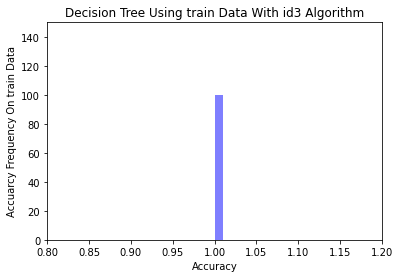

In [246]:
plothist('train', 'id3', 197, 'blue')
# plothist('test', 'all', 397)

### Q2.2 (12 Points) 
##### In the second histogram, you should show the accuracy distribution when the algorithm was evaluated over testing data. The horizontal axis should show different accuracy values, and the vertical axis should show the frequency with which that accuracy was observed while conducting these 100 experiments/training processes. You should also report the mean accuracy and its standard deviation.

The mean accuracy is 0.9410344827586203, and the std is 0.02392655119376817


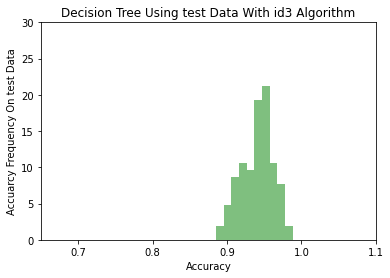

In [247]:
plothist('test', 'id3', 397, 'green')

### Q2.3 (12 Points) 
##### Explain intuitively why each of these histograms look the way they do. Is there more variance in one of the histograms? If so, why do you think that is the case? Does one histogram show higher average accuracy than the other? If so, why do you think that is the case?


Answer:

It is very apparent that, comparing the result of testing and the training data vs. the accuracy. In the aspect of variance, it's clear that the traverse of training data using decision tree model trained using training dataset is less variant, with mean accuracy is 1.0, and the std is 0.0. That means for all instance in training item, we are able to get the correct prediction. While for the accuracy, the training data is very accurate, indeed, it's 100% accurate. This is the case because since the instance of training data is always on the list, so the way we traverse the tree is exactly the same the way we trained it, hence 1.00 accuracy.

And for the testing data instance is The mean accuracy is 0.9410344827586203, and the std is 0.02392655119376817. Obviously more variance because larget std, but still not very big: range between 0.89 to 0.99, mean around 0.94, which is a very acceptable prediction result for me. It's less accurate because there are probably some instance that are outliers, or the tree running out of the subnode so we use the 'majority' vote way to determine the label.

### Q2.4 (8 Points) 
##### By comparing the two histograms, would you say that the Decision Trees algorithm, when used in this dataset, is underfitting, overfitting, or performing reasonably well? Explain your reasoning.


Answer: 

For the training dataset, I would say it is definitely overfitting, since we have 100% accuracy, which is almost impossible in real world. The decision tree fit too many attributes of the tree which would cause larger space complexity if the data is more than 17 attribute we are having in the example mini dataset. 

For the testing dataset, though I'd like to say it's performing reasonably well, there's still a little portion that the result is overfitting: if we restrict the layer of the decision tree, so we might have sub....treenode entropy not equal zero, that would be more realistic in realworld, since if there is one branch/one leaf node that have very deep layer, even though that might give us the correct result, but the process could consider to be redundant, hence might be overfitting.


### Q2.5 (6 Points) 
##### In class, we discussed how Decision Trees might be non-robust. Is it possible to experimentally confirm this property/tendency via these experiments, by analyzing the histograms you generated and their corresponding average accuracies and standard deviations? Explain your reasoning.

Answer:

In fact, if check on the gini part and the compariasion part below, we can find out the result varies with std around 0.02±0.005. Even though that might be small, but since we hav eall the data from the same 435 datas, the only difference is how we shuffle them again and again, so we can tell there's no large difference between all the reshuffles (Not like, for example trees in Europe and Trees in America and trees in Asia, which might have huge difference). All the data are from same 435 instance and say if we reshuffle them perfectly, for the training data, the tree would have at least 261 instances being the same as last shuffle. In average there should be only about 49 instance that are difference from last shuffle. But giving this, we can still find out that the result range from 0.89 to 0.99, hence that could show us that decision trees might be non-robust or less abstracly decribe, non-stable.

### Extra points (15 Points) 
##### Repeat the experiment above but now using the Gini criterion for node splitting, instead of the Information Gain criterion.

The mean accuracy is 1.0, and the std is 0.0


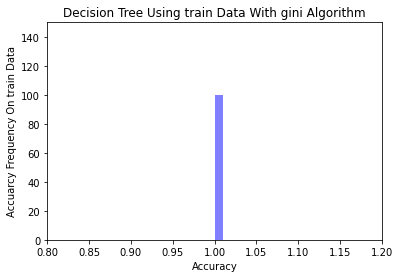

The mean accuracy is 0.9408045977011491, and the std is 0.023744745126567355


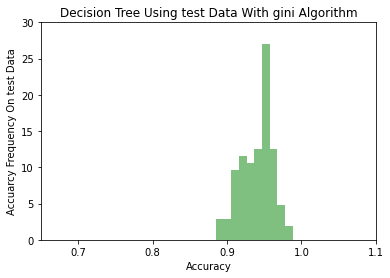

For ID3/infogain, The mean accuracy is 0.9395402298850576, and the std is 0.022146654444370282
For CART/gini, The mean accuracy is 0.93816091954023, and the std is 0.02167390653149791


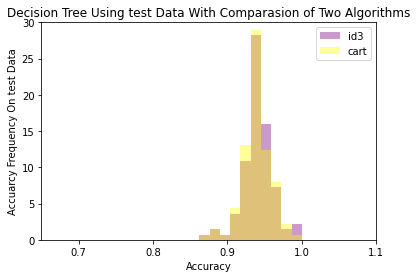

Now try compare Gini/CART with InfoGain/ID3 with another random value: 245.
For ID3/infogain, The mean accuracy is 0.9397701149425286, and the std is 0.019514519935360193
For CART/gini, The mean accuracy is 0.9399999999999998, and the std is 0.018927513298836497


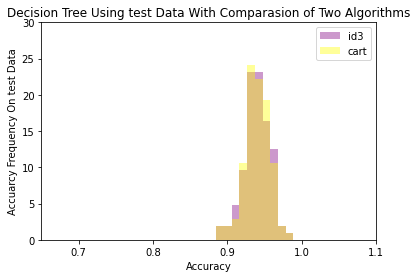

Now try compare Gini/CART with InfoGain/ID3 with another random value: 589.
For ID3/infogain, The mean accuracy is 0.9389655172413792, and the std is 0.024312178947685965
For CART/gini, The mean accuracy is 0.9375862068965516, and the std is 0.022772258772165557


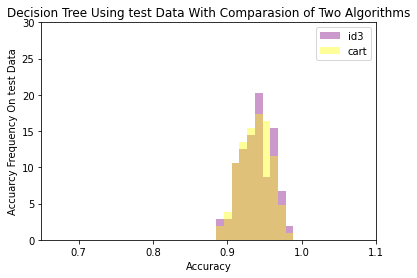

In [249]:
plothist('train', 'gini', 197, 'blue')
plothist('test', 'gini', 397, 'green')
plothist('test', 'all', 691)
print('Now try compare Gini/CART with InfoGain/ID3 with another random value: 245.')
plothist('test', 'all', 246)
print('Now try compare Gini/CART with InfoGain/ID3 with another random value: 589.')
plothist('test', 'all', 589)

We can roughly find out that the id3/infoGain and cart/gini gives similar accuracy, and the similar performance. But comparatively, gini seems to have smaller std than infoGain, hence less variant and probably less non-robust.